In [7]:
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures

# Machine Learning
### Neural Networks and Non-Linear Regression

## Linear and Non-Linear Regression

#### The Limitations of Linear Models

Recall that in linear regression, the model is linear: the function $\hat{f}$, which estimates the assumed real relationship $f$, is composed of constant parameters which multiply or add-to variable terms. 

$\hat{f}(X; \vec{w}) = X\vec{w} = w_1x_1 + w_2x_2 + \dots$ 

This is quite a limited as most datasets include relationships which cannot be fully captured by a linear (straight line) model.

In [8]:
e = np.random.normal(0, 0.1, 100)
x1 = np.arange(0, 1, 0.01)
y = 3*x1**2 + x1  + e

xv = x1.view().reshape(-1, 1)

yhat = LinearRegression().fit(xv, y).predict(xv)

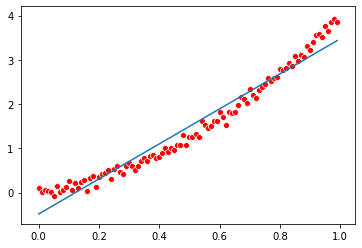

In [9]:
sns.lineplot(x1, yhat)
sns.scatterplot(x1, y, color="red");

### Exercise

* Consider $y$ to be a sale profit in £1,000s and $x1$ is the sale price of a home in £1,000,000s
    * Score the linear regression model above: how well does it fit the data?
    * Interpret this score in the light of the problem
    * Interpret the prediction line in three regions:
        * 0.0 to 0.2
        * 0.2 to 0.8
        * 0.8 to 1.0
        
    * what is the model doing?
    * what are the financial implications?


#### Generalizing Linear Models


What we would like is a convenient, systematic way to add additional structure to the model in order to capture real structure in the data. 

This is easy enough if the model is *just* a little more complex than a linear model:

eg., for a quadratic relationship,

$f(x; \vec{w}) = w_1x^2 + w_2x + w_3$

or, more generally,

$f(x; \vec{w}) = w_1a_1(x) + w_2a_2(x) + \dots$

ie., where each $x$ term is just given some additional structure by an $a$ function and then we learn how much of that kind of structure we should include (ie., the $w$).

Here `PolynomialFeatures(2)` adds structure to the `x`.

It sets $a_1(x) = 1$, $a_2(x) = x$ and $a_3(x) = x^2$ . 

(nb. if we choose `PolynomialFeatures(3)` we get $a_4(x) = x^3$, etc.).

In [10]:
z = PolynomialFeatures(2).fit_transform(xv) #

In [15]:
(1, x1[1], x1[1] ** 2) == z[1] # the first point in z is (1, x, x^2)

array([ True,  True,  True])

We can fit weights *linearly* to *this structure*: given each feature has already been $a$'d, it's just a linear combination of weights with the output from each $a$.

ie., $\hat{f}(x_1; w_1, w_2, w_3) = w_1a_1(x_1) + w_2a_2(x_1) + w_3a_3(x_1) = w_1 + w_2x_1 + w_3x_1^2$

is just $\hat{f}(z; w_1, w_2, w_3) = w_1 + w_2z_2 + w_3z_3$

In [16]:
model = LinearRegression().fit(z, y)
yhatz = model.predict(z)

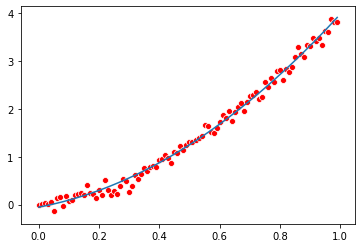

In [50]:
sns.lineplot(x1, yhatz)
sns.scatterplot(x1, y, color="red");

### Exercise

The spread of disease is typically exponential. 

Model the spread of disease over 30 days ($x \in [1, 30]$) with $y = 5e^{0.05x}$.

* How many people are infected on day 30?
* Model this data set using a quadratic curve and interpret the model. 
    * Is a quadratic a good model of an exponential?
    * What does the score tell you?
    * How well does a quadratic model explain an exponential process?

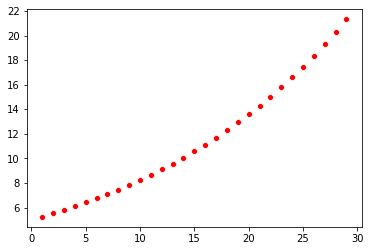

In [908]:
x_days = np.arange(1, 30).reshape(-1, 1)
y_people = 5*np.exp(0.05*x_days[:, 0])

sns.scatterplot(x_days[:, 0], y_people, color="red");

In [909]:
y_people[-1]

21.315572575844094

In [901]:
x2_days = PolynomialFeatures(2).fit_transform(x_days)
model_ppl = LinearRegression().fit(x2_days, y_people)

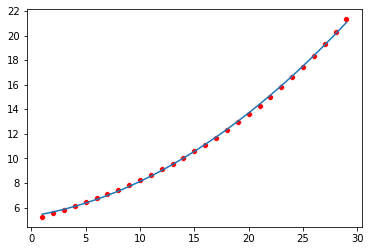

In [902]:
sns.scatterplot(x_days[:, 0], y_people, color="red");
sns.lineplot(x_days[:, 0], model_ppl.predict(x2_days));

In [904]:
model_ppl.score(x2_days, y_people)

0.9995178348437185

A qudratic model of an exponential process is a *very bad* **explanatory** model! The quadratic predicts an ever decreasing rate of disease spread compared to what we actually see!

Let's look at one year of disease spread:

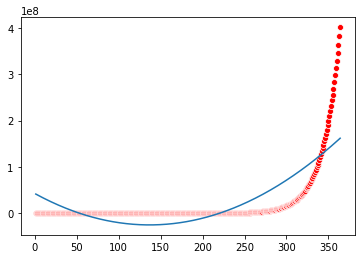

In [911]:
x_days = np.arange(1, 365).reshape(-1, 1)
x2_days = PolynomialFeatures(2).fit_transform(x_days)
y_people = 5*np.exp(0.05*x_days[:, 0])
model_ppl = LinearRegression().fit(x2_days, y_people)
sns.scatterplot(x_days[:, 0], y_people, color="red");
sns.lineplot(x_days[:, 0], model_ppl.predict(x2_days));

The quadratic model predicts a *decrease* from 0 to 100 days! And fails to notice an explosion at c. 325 days!

## Beyond Polynomial Regression

A problem arises when we don't know how complex the data is: how many parameters do we need? What should we choose for $a$ ?

For image data, each 1024x1024 1MP image contains 1 million pixels and therefore 1 million $x$ terms. Is the model which maps an image to a prediction *linear*? That seems unlikely: so... how complex should our function be to ensure we are capturing *real* patterns in the data?


Consider a non-linear relationship in the breast cancer dataset...

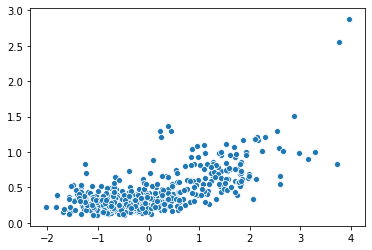

In [230]:
from sklearn.datasets import load_breast_cancer as loadbc

X = loadbc()['data'][:, [0, 10]]

xbc, ybc = (X[:, 0], X[:, 1])

xbc = (xbc - xbc.mean())/xbc.std() # centre on zero (discussed later)

sns.scatterplot(xbc, ybc);

### A Receipe for Regression 

What regression function should we use to model this?

Rather than answer that question let's come up with a receipe for building a complex regression function:

$\hat{f}(x; \vec{w}) = w_na(w_{n-1}a( \dots w_1a(\dots wx +b)) = z_n(z_{n-1}(\dots))$

What we're going to do is take the output of $a_1(wx + b)$ and run it through $N_L$ number of other $a$s which each add more and more non-linearity to the model. 

We can read $N_L$ as the number of non-linearities, or the number of "layers" (defining *layer* to mean the introduction of a non-linear operation $a$).

In the $\hat{f}$ below, three non-linear terms are used each having a weight and bias (a pair of parameters) each. The goal of learning is to find suitable values for $w$ and $b$ -- we choose $a$.

```python
def fhat(x, w, b, a):
    return w[3] * a( w[2] * a( w[1] * a( w[0] * x + b[0]) + b[1]) + b[2]) + b[3]

```

If we choose a simple $a$, and keep every $a$ the same, then $a$ by itself add little additional structure. However if we then add many entires to $w$ and to $b$ we, in effect, get lots of $a$s. We can build up an abitarily complex function, then, just by choosing a simple $a$ and *abitarily increasing* the number of parameters. The *number of parameters* then becomes an easy dial for increasing model complexity in a systematic way. 

#### Choosing $a$
The ReLU operation ("rectified linear unit") is $f(x) = x$ when positive ($\forall x >= 0$) and $f(x) = 0$  when negative ($\forall x < 0$). This is perhaps the simplest, or nearly the simplest, possible non-linear function. With just this single "bent line" we can build up abitarily complex shapes by composing a large number of such lines together.  

Sigmoid is also defined, an S-curve, which can build smoother shapes more quickly (ie., with fewer $a$ terms) but is more computationally expensive and harder to train (ie., its harder to find $w$ and $b$).

Both of these choices of $a$ require their input to be centred around $0$ (their nonlinear section) for training to be successful (hence, above, `xbc` was centered on zero). 

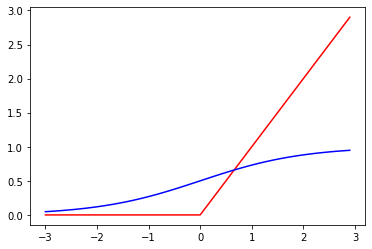

In [234]:
z = np.arange(-3, 3, 0.1)

sns.lineplot(z, relu(z), color="red")
sns.lineplot(z, sigmoid(z), color="blue");

For example,

In [231]:
def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def fhat(x, w, b, a=relu):
    return w[3] * a( w[2] * a( w[1] * a( w[0] * x + b[0]) + b[1]) + b[2]) + b[3]

In [232]:
fhat(10, [1, 1, 1, 1], [-1, -1, -1, -1])

6

Using `fhat` to predict for the breast cancer set:

/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


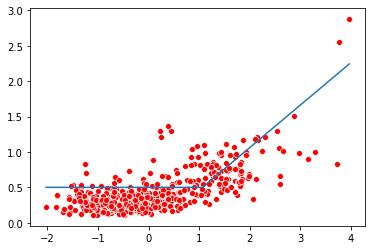

In [274]:
# suppose we learn these 
w, b = [1, 3, 0.4, 0.5, 0.2], [-0.3, -0.3, -0.8, 0.5]

# then
sns.scatterplot(xbc, ybc, color="red")
sns.lineplot(xbc, fhat(xbc, w, b));

Here you can see we have learn a simple varation on the shape of ReLU: more parameters would be needed to increase the complexity of the line structure.

Switching to sigmoid, we can get a smoother interpolation with the same number of terms. (It is not clear *either* is a good fit...)

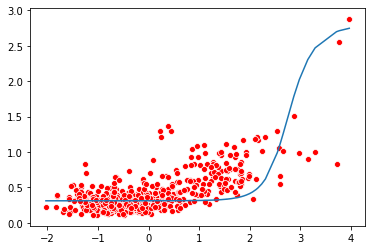

In [235]:
w, b = [-3, 4, -3, 6], [7.5, -1, 1, -0.5]

sns.scatterplot(xbc, ybc, color="red")
sns.lineplot(xbc, fhat(xbc, w, b, a=sigmoid));

### Exercise

* Vary the parameters of both regression functions
    * What effect does each $b$ term have?
        * try negative and positive numbers
    * What effect does each $w$ term have?
    * Why do the models often end up linear?

#### Aside: Why build a regression function by composition?

There's lots of ways of building an abitarily-complex regression function (eg., 
taylor series, etc.) -- but this way gives us a simple receipe to *train* it. If we build it up just using a series of chained functions, there is a simple way to find the parameters: the chain rule.

Find the error of each $z_n = a_n(\dots)$ term and recursively multiply in order to compute the error on $\hat{y}$ due to the $w_n$ of interest: if you know the error due to $w_n$, you can improve $w_n$.

This receipe also means that you can compute the function in a simple loop: rather than in a large "at-once" calculation as in `fhat`. Just compute each $z_n$ using $z_{n-1}$ as the input: $z_n = a_n(z_{n-1})$ where $z_0 = x$ and therefore $z_{N_L} = \hat{y}$) -- ie., the first "layer" is taken to be the input $x$ and thus the last "layer" is the output $\hat{y}$. 

When training, you store the intermediate $z_n$ values in the "forward pass" (the loop to compute the output) so the the "backward pass" (loop to update weights) can quickly compute errors.  

In [822]:
x = 0.1
w, b = np.arange(1, 5), np.arange(1, 5)

In [872]:
def fhat(x, w, b, a=relu):
    return w[3] * a( w[2] * a( w[1] * a( w[0] * x + b[0]) + b[1]) + b[2]) + b[3]

def forward_pass(x, w, b, a=relu):
    # number of layers,  ie., how many calls to a()
    n = len(w)
    
    # layer outputs, also called "activations"
    # start with all zero
    z = [None] * n   
    
    # the first layer is the input, x
    z[0] = x 

    # apply a() to all layers except the last
    for i in range(0, n - 1):
        z[i + 1] = a(w[i] * z[i] + b[i])
        
    # last layer is the output
    # same linear form, no a()
    yhat = w[-1] * z[-1] + b[-1]
    
    return yhat


print("Forward Pass: x = 0.1, yhat = ", forward_pass(x, w, b))
print("Direct Calc: x = 0.1, yhat = ", fhat(x, w, b))

Forward Pass: x = 0.1, yhat =  66.4
Direct Calc: x = 0.1, yhat =  66.4


Note how the `forward_pass` approach let's the number of parameters implicitly define the model, so we can just supply (an abitary number of) parameters and let the model grow in complexity to match:

In [873]:
forward_pass(0.1, np.random.normal(0, 1, 100), np.random.normal(0, 1, 100))

-0.15565635214048104

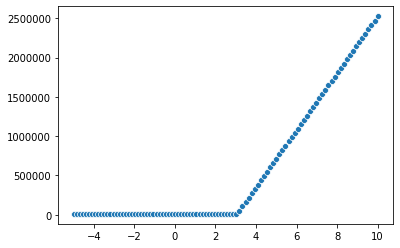

In [875]:
xtest = np.linspace(-5, 10, 100)
wt, bt = np.arange(1, 10), np.random.normal(0, 3, 100)

sns.scatterplot(xtest, forward_pass(xtest, wt, bt));

#### Defining a Non-Linear Regression Function

Rather than write out a huge and complex model, we can use sklearn to define and train such a regression function.

In general we'll want quite a few non-linear terms (eg., from 2 to 200) and each will require a large number of parameters to find to a complex shape. 

Each $a$ gets a $w, b$ but we can make those abitarily large, ie., we can have a $w \in R^{NxM}$ -- a matrix of weights!

To define such a complex model we only need to specify two hyperparameters: how many non-linear terms we want, and how many biases per term. The number of biases, $b$, sets the size of the weights, $w$ and can be read as the number of times we want $a$ to be independently computed; ie., there's one bias per one activation. 

In [241]:
from sklearn.neural_network import MLPRegressor

Nl = (10, 10, 10, 10)

xbcv = xbc.view().reshape(-1, 1)

nn = MLPRegressor(Nl, random_state=0).fit(xbcv, ybc)
yhatnn = nn.predict(xbcv)


/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


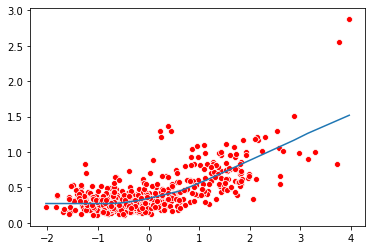

In [242]:
sns.scatterplot(xbc, ybc, color="red")
sns.lineplot(xbc, yhatnn);

### Exercise

Build a neural network model of the simulated disease dataset above. 
* Is this better than quadratic?
* Increase the number of parameters in each layer from `10` to `100` to `1000` 
    * what effect does adding parameters have?
    * how many parameters does it take for the neural network to converge (stabalize in its predictions)?

In [943]:
from sklearn.neural_network import MLPRegressor

Nl = (10_000,100)

#nn = MLPRegressor(Nl, max_iter=1000, activation="sigmoid").fit(x_days[:30, :], y_people[:30])
nn = MLPRegressor(Nl, max_iter=1000).fit(x_days, y_people)


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


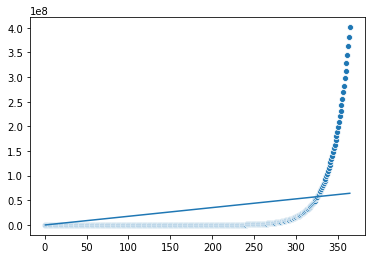

In [944]:
sns.scatterplot(x_days[:, 0], y_people)
sns.lineplot(x_days[:, 0], nn.predict(x_days));

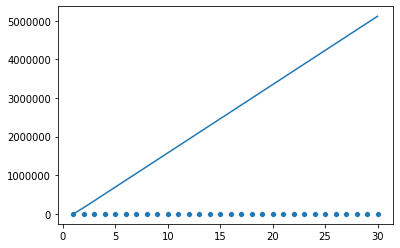

In [945]:
sns.scatterplot(x_days[:30, 0], y_people[:30])
sns.lineplot(x_days[:30, 0], nn.predict(x_days[:30,:]));

#### The Model 

This regression system learns the model...

$\hat{f}(x) = W_4a(W_3a(W_2a(W_1X_1 + b_1) + b_2) + b_3) + b_4$

In [238]:
print(f"N_L: {nn.n_layers_}, Non-Linearity: {nn.activation}")

N_L: 6, Non-Linearity: relu


In [243]:
w0, w1, w2, w3, w4 = nn.coefs_
b0, b1, b2, b3, b4 = nn.intercepts_

In [244]:
structure = xbcv.shape[1], len(b0), len(b1), len(b2), len(b3), len(b4)

print(f"Layer sizes: {structure}")

Layer sizes: (1, 10, 10, 10, 10, 1)


In [245]:
wsize = [ w.shape[0] * w.shape[1] for w in nn.coefs_ ]
totalp = sum(structure) + sum(wsize)

print(f"Weights: {wsize}")
print(f"Total parameters: {totalp}")

Weights: [10, 100, 100, 100, 10]
Total parameters: 362


#### Aside: Reconstructing the Model

In [255]:
x = xbcv[0:1, :]

In [256]:
nn.predict(x)

array([0.58846092])

Sklearn returns the weight matrix such that the formula for applying it is `x @ w`, hence the function is:

In [257]:
b4 + relu (b3 + relu( b2 + relu( b1 + relu( b0 + x @ w0  ) @ w1) @ w2) @ w3) @ w4

array([[0.58846092]])

Or, via the looping approach:

In [259]:
n = len(structure)    # number of layers
a = [relu] * (n - 1)  # activation of each layer
z = [None] * n        # output of each layer


z[0] = x              # take x as the first input
a[-1] = lambda x: x   # last layer has no activation fn 


for i in range(0, n - 1):
    z[i + 1] = a[i](z[i] @ nn.coefs_[i] + nn.intercepts_[i])
    
    
# prediction is the output of the last layer

print(f"yhat = {z[-1]}")

yhat = [[0.58846092]]


#### The Structure

Given a complete structure, $(1, 2, 3, 1) = (N_x, N_{b1}, N_{b2}, N_y)$ we read as $x$ having one column, the first $a$ as producing two outputs which each require a bias, the second $a$ producing 3, and finally $y$ being a single column (one for every x).

The number of biases needed for a layer matches its number of outputs, and can be interpreted as "the number of times $a$ is independently run". Each of these runs is computing a seperate line, and so the parameter matrices track many concurrent relationships before aggregating into a single final prediction.

#### Aside: Understanding the Structure

Consider the function, $y = g_1(x) = wa(x) + b$ . If $x = (10, 20)$ and we need a single-number prediction for $y$, then w should contain two weights which perfom a weighted-sum (dot product) with $x$. Eg., let's take $a(x) = x$, and suppose $w = (2, 3)$ and $b = 1$ then $y = 10*2 + 20*3 + 1 = 51$. 

Now let's add a second layer:  $y = g_2(x) = w_2a_2(w_1a_1(x) + b_1) + b_2$.

Notice that whatever we input, $w_2 * (\dots)$ has to give us a single-number output. Suppose we choose now a more complex array for $w_1$, this prodces more parameters to be passed into $a_2$ which requires more parameters in $w_2$. 

The constraint is really just that the last set of weights, $w_2$ reduce everything down to a single number. But by increasing the size of the intermediate weight terms (here just $w_1$) we can have many relationships being learnt which all then just aggregated at the end.

To specify all this we say: $(N_i, Z_0, Z_1, \dots, N_o)$ where each entry in the tuple corresponds to the number of outputs of each layer. The first entry must correspond to the first input layer (ie., $x$) and the last is constrained so that the output layer (ie., $y$ is a single number. In the middle, we are free to choose the number of layers we want, and how many outputs each should have $Z_n$ -- by playing around with these number's we're able to learn increasingly complex shapes. 

This is the meaning of the specification $(10, 10, 10, 10)$ which is a partial description of the regression function. In sklearn you do not specify the input/output shape are these are set by other arguments (eg., the shape of $X$). 


# What is an MLP?

A Multilayer Perceptron is a fully-connect neural network. Rather than introduce Neural Networks diagramatically (as is often done), we have started with Linear Regression, then Polynomial Regression and finally a slight generalization we call "A Neural Network".

This is to properly situate the technique within the standard regression tradition, and to demystify it's mode of operation and purpose. We will shortly review how neural networks are often diagrammed and described -- but these visuals very poorly inform their viewer of *the problem* and its *solution*. Rather they are helpful in thinking about how layers of the model should be structured, ie., these visuals are a tool for building the model -- not for understanding the technique. 

## The Model Diagram



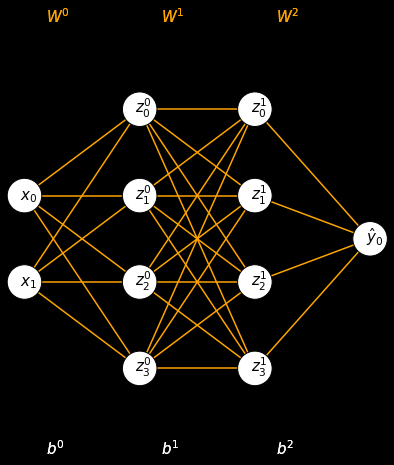

In [766]:
draw_neural_net([2, 4, 4, 1])

In the diagram above we have an $X$ input with two features (/columns), $x_0$ and $x_1$. Each line connecting these represents one entry in the weight matrix for the first layer, $W^0$. Here then you can count four weights (egdges) per node in the first layer, and so there $W^0$ has 8 entires. Likewise for the second layer, $W^1$ has 16 entries, and $W^2$ has 4.

The bias terms are sized according to the number of *nodes* so $b^0$ has 2 entires, $b^1$ and $b^2$ have 4. Note that the superscript denotes the layer number, $W^{layer}$.

### Terminology

Each node is said to be a "neurone" which is computed by an *activation function* $a$. We can also just call these numbers the input/output of the layer (a relative term) and $a$ the non-linearity. 

The layers marked $z$ are known has "hidden" in the sense that that model takes as input $x$ and produces $y$, so these values aren't exposed in the computation. They arent "hidden" in any more meaningful sense, as it is trivial to obtain the value of these weights --  a better term would've been "middle layers" or "training layers". 

The graph of the `MLPRegressor` network above with `structure`:

In [767]:
structure

(1, 10, 10, 10, 10, 1)

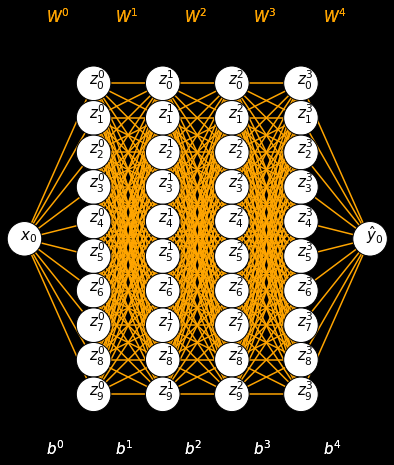

In [765]:
draw_neural_net(structure)

### Exercise

* Draw the network diagram for any of the problems / examples used in this notebook

* EXTRA:
    * write the corresponding regression function

### Diagram to Model

These visualizations omit the chosen activation function. Suppose we take $a(x) = x$, ie., a linear regression -- then the following diagram corresponds to:

$\hat{y} = W^1a^1(a^0(W^0x_0 + b^0)) + b^1 = W^1W^0x_0 + b^0 + b^1 = Wx + b $

Note that the diagram reads in the opposite direction of the formula. This direction more closely resembles the forward pass loop, in which you start with the input $x$ and loop to caclulate each term of the model. 

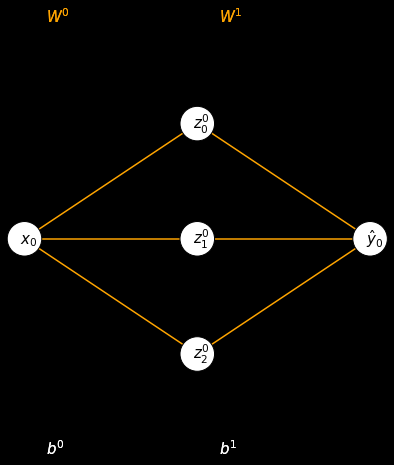

In [769]:
draw_neural_net([1, 3, 1])

## Next Steps

This notebook has primarily been a discussion of non-linear regression and how neural networks are helpful for solving non-linear problems. It has not considered neural networks very deeply, on their own terms. To move forward we need to consider (1) real-world libraries for neural networks; and (2) deep learning. 

Sklearn is rarely used in actual network design and deployment (rather tensorflow or pytorch) as it does not build optimal computational structures nor provide any tools for working with complex datasets (images, audio, etc.).  

And a whole field of "deep learning" exists in which neural network architectures can run to 100s of layers deep with 100s nodes/layer and billions of parameters. Designing deep networks is a complex activity, however for key problems (text, images, etc.) off-the-shelf network designs often exist. 


## Some Final Remarks on Neural Networks

####   Neural Networks are neither Neural nor Networks

"Neural networks" are neither neural nor networks, having no obvious *graph* representation special to the algorithm nor any correspodance to any neural biological process. As *computational graphs* every computable mathematical function can be drawn as a network. As a *diagram* yes, but there is no obvious way of representing this as an actual graph.

Sometimes they are taught "as inspired by neuron firing" but this applies, very imperfectly, to a toy 1940s model. The idea was the "forward pass" which computes the output of the model would encode the conditional firing activity of neurons: however no modern network encodes such behaviour, nor did the original, nor has any included *most* of the biological activity of neurones, vitally missing the dynamical adaption of neuronal structure over time (and biochemical signalling).

The "backward pass", ie., the training phase, has *no* biological correspondance. What makes neural networks *a learning algorithm* and  useful is that they can be trained using a simple optimizing process -- yet this process has no biological counterpart and was, indeed, not part of models which served as primitive neural simulations. 

A "neural network" is inspired by those early approaches to modelling nerve firing, but as soon as you chage the algorithm to: (1) parameter optimization; and (2) curve fitting to data -- it ceases to be even a toy model of neurones. It is, instead, simply non-linear regression -- of a form that we have been used to for well over a century.

Indeed, it would be rather prohibitive if neural networks imitated brain structure: we want the structure of the regression function to match the structure of the target data -- not that of an animal brain! (which is surely less optimial for almost every problem which can be solved by regression). 

#### Aside: On Animal Intelligence

Even if the regression function encoded -- somehow -- the same sorts of hormonal and electrical cascades that occur in animal brains, *that it trains on data* still renders it a very limited substitue for an animal. 

Animals directly interact with their environment: it isnt the structure of their thought *fixed at some point in time* which constitues "intelligence", rather how that structure adapts as a direct response to a changing environment. Consider building a set of *all* the thoughts you could think to solve problem X -- now make some small change to the problem -- and suddenly, this set is incomplete at best (and probably uselss). If you understand thinking this way, you quickly run into infinities: the set of all possible thoughts is infinite, and there is no finite process to choose from this infinite set! *Understanding* is then, *not* selecting thoughts: it is *generating* them.

General, animal, intelligence does not have a "training phase on data", nor is it reducible a set of thoughts -- it is in constant training *in response to* dynamically changing, novel, experiences that *the animal* both causes and reacts to. It's "training" is not to solve a problem, but to adapt the brain *to a problem* in order to solve it (ie., *learning*!). Our environment *literally* restructures our brain to generate *new* thoughts. 

Even a machine built by perfectly emulating the biological stucture of an animal's brain, as it perfectly solves some problem, will not generalize that solution. The machine itself must adapt over time, and react to their environments, *as brains do*. This process is biological, resulting from the causal interactions of specific biological matter. The underlying processes which geneate thoughts (and connections between them) may be irreducibly biological and products of specialized reactions that take place across animal bodies (eg., how heat impacts nerves in the hand).

If we ever build an artifical general intelligence, "training data" will never be enough -- no matter the quantity. The world presented *as data* leads to sets of infinites. No *algorithm* will be sufficient. The machine will need be built from specialized mateirals (probably organic) which *react* and *adapt*, generating its own data (as we do). And then, finally, this machine will need to spend many decades amongst people to even begin to understand what we mean, what we want, and how to help. 

### Appendix: Code

In [763]:
import matplotlib.pyplot as plt
from statistics import mean

def draw_neural_net(layer_sizes, nodenames=None, size=6):
    if nodenames is None:
        nodenames = (
            [['$x_{%d}$' % i for i in range(layer_sizes[0])]] +
            [['$z^{%d}_{%d}$' % (l,i) for i in range(n)] for l, n in enumerate(layer_sizes[1:-1])] +
            [['$\hat{y}_{%d}$'% (i) for i in range(layer_sizes[-1])]]
        )
        
    ax = plt.figure(figsize=(size, size), facecolor="black")
    left, right, bottom, top = .1, .9, .1, .9,
    ax.gca().axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/max(layer_sizes)
    h_spacing = (right - left)/(len(layer_sizes) - 1)

    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.

        if n != len(layer_sizes) - 1:
            ax.add_artist(plt.text(
                n*h_spacing + 1.5*left, 0,
                '$b^{%s}$' % n, fontsize=15, color="white", transform=ax.transFigure, zorder=10
            ))

            ax.add_artist(plt.text(
                n*h_spacing + 1.5*left, 1.0,
                '$W^{%s}$' % n, fontsize=15, color="orange", transform=ax.transFigure, zorder=10
            ))
            
        for m in range(layer_size):
            circle = plt.Circle(
                (n*h_spacing + left, layer_top - m*v_spacing), 
                radius=0.04, color='w', ec='k', zorder=4
            )
            
            ax.add_artist(plt.text(
                circle.center[0] - 0.1*left, circle.center[1] - 0.05*v_spacing,
                nodenames[n][m], fontsize=15, transform=ax.transFigure, zorder=10
            ))
            
            ax.add_artist(circle)


    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                px = [n*h_spacing + left, (n + 1)*h_spacing + left]
                py = [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing]
                
                line = plt.Line2D(px, py, color="orange")
                ax.add_artist(line)
                
                